In [1]:
import numpy as np
import pandas as pd
from pygam import LinearGAM, s, f
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.metrics import root_mean_squared_log_error as rmsle
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score

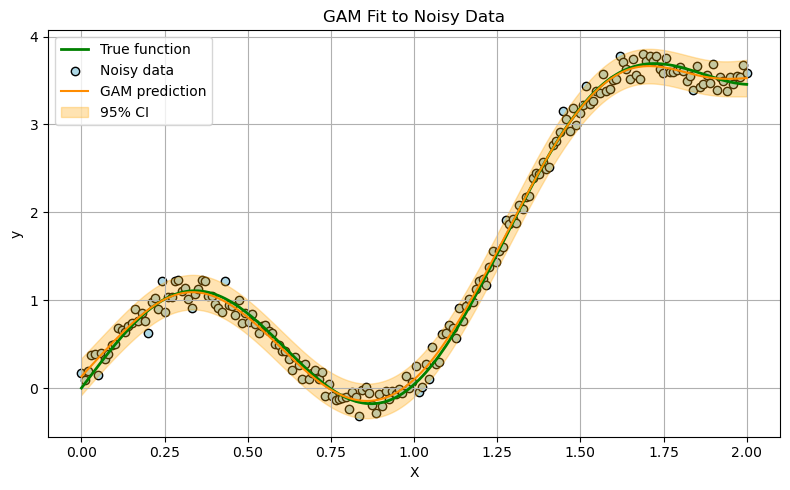

In [ ]:
# Generate data
np.random.seed(0)
X = np.linspace(0, 2, 200)[:, np.newaxis]  # pyGAM expects 2D input
y = np.sin(5 * X).ravel() + X.ravel() ** 2 + np.random.normal(0, 0.1, 200)

# Fit GAM
gam = LinearGAM(s(0)).fit(X, y)


# Predict
XX = np.linspace(0, 2, 1000)[:, np.newaxis]
y_pred = gam.predict(XX)
y_conf = gam.prediction_intervals(XX, width=0.95)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(X, np.sin(5 * X) + X**2, label='True function', color='green', linewidth=2)
plt.scatter(X, y, facecolor='lightblue', edgecolor='k', label='Noisy data')
plt.plot(XX, y_pred, color='darkorange', label='GAM prediction')
plt.fill_between(XX.ravel(), y_conf[:, 0], y_conf[:, 1], color='orange', alpha=0.3, label='95% CI')
plt.xlabel('X')
plt.ylabel('y')
plt.title('GAM Fit to Noisy Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.3051
Link Function:                     IdentityLink Log Likelihood:                                  -9113.613
Number of Samples:                          200 AIC:                                            18251.8362
                                                AICc:                                           18253.5901
                                                GCV:                                                0.0106
                                                Scale:                                              0.0096
                                                Pseudo R-Squared:                                   0.9953
Feature Function                  Lam

C:\Users\eblac\AppData\Local\Temp\ipykernel_14580\3358381670.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


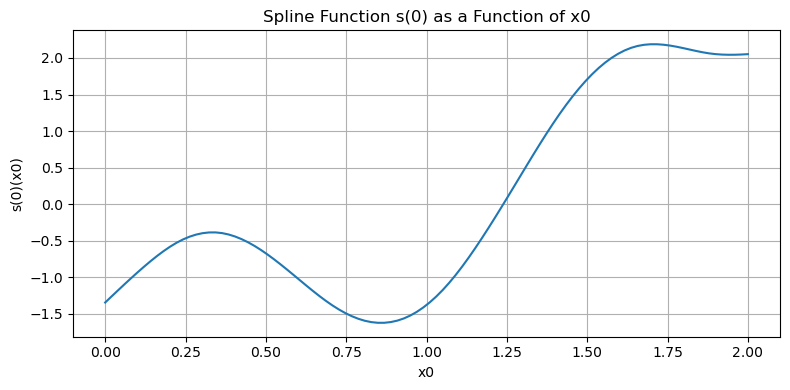

In [19]:
# Create a grid of values for feature 0
XX = gam.generate_X_grid(term=0)  # generates values for feature 0 while holding others at median

# Get partial dependence values for term 0
pdep = gam.partial_dependence(term=0, X=XX)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(XX[:, 0], pdep)
plt.xlabel('x0')
plt.ylabel('s(0)(x0)')
plt.title('Spline Function s(0) as a Function of x0')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
gam.coef_

array([-1.83553509, -1.34415507, -0.85180798, -0.44812361, -0.33238607,
       -0.55254073, -0.97025618, -1.4115554 , -1.66009081, -1.59807451,
       -1.18525705, -0.45818805,  0.40247121,  1.25596206,  1.88936174,
        2.21077922,  2.18539672,  2.0342176 ,  2.04440185,  2.100889  ,
        1.47550884])

In [20]:
train = pd.read_csv("train_comp.csv")
test = pd.read_csv("test_comp.csv")
# sample = pd.read_csv("sample_submission.csv")

train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,male,36,189,82,26,101,41.0,150
1,female,64,163,60,8,85,39.7,34
2,female,51,161,64,7,84,39.8,29
3,male,20,192,90,25,105,40.7,140
4,female,38,166,61,25,102,40.6,146


In [23]:
X = pd.get_dummies(train.drop(columns='Calories'), drop_first=True)
y = np.log1p(train['Calories'])

test_mod = pd.get_dummies(test, drop_first=True)

In [35]:
n_numeric = len(X.columns) - 1  # number of numeric features
n_features = X.shape[1]         # number of features


# Optuna objective with cross-validation
def objective(trial):
    spline_orders = []
    n_splines_list = []
    lams = []

    # Tune splines for numeric features only
    for i in range(n_numeric):
        lam = 1 # trial.suggest_float(f"lam_{i}", 0.001, 10, log=True)
        spline_order = trial.suggest_int(f"spline_order_{i}", 1, 3, step=2)
        n_splines = trial.suggest_int(f"n_splines_{i}", 5, 20)

        lams.append(lam)
        spline_orders.append(spline_order)
        n_splines_list.append(n_splines)

    # Use default lam=1 for categorical features (we won't spline them)
    for i in range(n_numeric, n_features):
        lams.append(1.0)


    # Define terms using customized splines
    terms = s(0, spline_order=spline_orders[0], n_splines=n_splines_list[0])
    for i in range(1, n_numeric):
        terms += s(i, spline_order=spline_orders[i], n_splines=n_splines_list[i])
    for i in range(n_numeric, n_features):
        terms += f(i)

    # 5-Fold Cross-Validation
    kf = KFold(n_splits=3, shuffle=True, random_state=724)
    scores = []
    for train_idx, val_idx in kf.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]

        gam = LinearGAM(terms, lam=lams).fit(X_train_cv, y_train_cv)
        preds = gam.predict(X_val_cv)
        model_score = rmse(y_val_cv, preds)
        scores.append(model_score)

    return np.mean(scores)

# Run Optuna
study = optuna.create_study(direction="minimize", study_name='GAM_tune_no_FE', storage="sqlite:///GAMs.db", load_if_exists=True)
study.optimize(objective, n_trials=50, timeout=3600)

# Final model on full data
# best_lams = [study.best_params[f"lam_{i}"] for i in range(n_numeric)]
# best_lams.append(1.0)
terms = s(0)
for i in range(1, n_numeric):
    terms += s(i)
for i in range(n_numeric, n_features):
    terms += f(i)

final_gam = LinearGAM(terms).fit(X, y)

# # Plot partial dependence functions
# print("\nPartial Dependence Plots:")
# for i, term in enumerate(final_gam.terms):
#     if term.isintercept:
#         continue
#     plt.figure()
#     XX = final_gam.generate_X_grid(term=i)
#     plt.plot(XX[:, term.feature], final_gam.partial_dependence(term=i))
#     plt.plot(XX[:, term.feature], final_gam.partial_dependence(term=i, width=0.95)[1], c='r', ls='--')
#     plt.title(f'Partial Dependence of Feature {i} ({X.columns[i]})')
#     plt.xlabel(X.columns[i])
#     plt.ylabel('Effect on Target')
#     plt.grid(True)
#     plt.show()

# Feature Importances
print("\nFeature Importances:")
importances = final_gam.statistics_['deviance explained']
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), X.columns, rotation=90)
plt.title("Feature Importances (Deviance Explained)")
plt.ylabel("Deviance Explained")
plt.tight_layout()
plt.show()

[I 2025-06-18 18:05:26,739] Using an existing study with name 'GAM_tune_no_FE' instead of creating a new one.
[I 2025-06-18 18:06:34,612] Trial 50 finished with value: 0.0900714001968576 and parameters: {'spline_order_0': 3, 'n_splines_0': 19, 'spline_order_1': 1, 'n_splines_1': 19, 'spline_order_2': 3, 'n_splines_2': 16, 'spline_order_3': 3, 'n_splines_3': 20, 'spline_order_4': 3, 'n_splines_4': 17, 'spline_order_5': 1, 'n_splines_5': 12}. Best is trial 47 with value: 0.0900524451948763.
[I 2025-06-18 18:07:54,865] Trial 51 finished with value: 0.09005472775150684 and parameters: {'spline_order_0': 3, 'n_splines_0': 19, 'spline_order_1': 1, 'n_splines_1': 18, 'spline_order_2': 3, 'n_splines_2': 18, 'spline_order_3': 3, 'n_splines_3': 19, 'spline_order_4': 3, 'n_splines_4': 20, 'spline_order_5': 1, 'n_splines_5': 20}. Best is trial 47 with value: 0.0900524451948763.
[I 2025-06-18 18:09:07,571] Trial 52 finished with value: 0.09005936333837535 and parameters: {'spline_order_0': 3, 'n_sp

KeyboardInterrupt: 

In [32]:
optuna.delete_study(study_name='GAM_tune_no_FE', storage="sqlite:///GAMs.db")

In [36]:
study.best_params

{'spline_order_0': 3,
 'n_splines_0': 20,
 'spline_order_1': 1,
 'n_splines_1': 20,
 'spline_order_2': 3,
 'n_splines_2': 15,
 'spline_order_3': 3,
 'n_splines_3': 20,
 'spline_order_4': 3,
 'n_splines_4': 20,
 'spline_order_5': 1,
 'n_splines_5': 20}

In [37]:
X.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Sex_male
0,36,189,82,26,101,41.0,True
1,64,163,60,8,85,39.7,False
2,51,161,64,7,84,39.8,False
3,20,192,90,25,105,40.7,True
4,38,166,61,25,102,40.6,False


In [ ]:
# Baseline GAM - Kaggle score 0.08945 private, 0.08850 public GAM_1.csv

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

# fit GAM
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + f(6)).fit(X_train, y_train)

# train score
train_pred = gam.predict(X_train)
print("Train RMSLE is:", rmse(train_pred,y_train))

# test score
test_pred = gam.predict(X_test)
print("Test RMSLE is:", rmse(test_pred,y_test))



# make the submission file!

pred = gam.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("GAM_1.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

Train RMSLE is: 0.0900430951340916
Test RMSLE is: 0.08996528009806895
       id    Calories
0  750000   28.101439
1  750001  106.982687
2  750002   89.638921
3  750003  129.353761
4  750004   74.608806

count    250000.000000
mean         88.193629
std          62.563083
min           1.350554
25%          33.964642
50%          76.184772
75%         134.871937
max         316.788817
Name: Calories, dtype: float64


In [ ]:
# Kaggle score 0.08946 private, 0.08849 public GAM_2.csv

# {'spline_order_0': 3,
#  'n_splines_0': 20,
#  'spline_order_1': 1,
#  'n_splines_1': 20,
#  'spline_order_2': 3,
#  'n_splines_2': 15,
#  'spline_order_3': 3,
#  'n_splines_3': 20,
#  'spline_order_4': 3,
#  'n_splines_4': 20,
#  'spline_order_5': 1,
#  'n_splines_5': 20}

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

# fit GAM
gam = LinearGAM(s(0, spline_order=3, n_splines=20)
                +s(1, spline_order=1, n_splines=20)
                +s(2, spline_order=3, n_splines=15)
                +s(3, spline_order=3, n_splines=20)
                +s(4, spline_order=3, n_splines=20)
                +s(5, spline_order=1, n_splines=20)
                +f(6)).fit(X_train, y_train)

# train score
train_pred = gam.predict(X_train)
print("Train RMSLE is:", rmse(train_pred,y_train))

# test score
test_pred = gam.predict(X_test)
print("Test RMSLE is:", rmse(test_pred,y_test))



# make the submission file!

pred = gam.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("GAM_2.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

Train RMSLE is: 0.09004628246690803
Test RMSLE is: 0.08996095163254603
       id    Calories
0  750000   28.071511
1  750001  107.049483
2  750002   89.584773
3  750003  129.586019
4  750004   74.511785

count    250000.000000
mean         88.193975
std          62.562966
min           1.361226
25%          33.958516
50%          76.175918
75%         134.876290
max         317.165713
Name: Calories, dtype: float64


In [49]:
numerical_features = ["Age","Height","Weight","Duration","Heart_Rate","Body_Temp"]

def add_feats(df, numerical_features):
    ''''''''''
    Inputs: dataframe df
    Output: the modified dataframe with cross terms, BMI, id+calories removed, and sex as categorical variable
    '''''''''
    df_new = df.copy()

    features = df_new.columns

    if 'id' in features:
        df_new = df_new.drop(columns=['id'])
    
    if 'Calories' in features:
        df_new = df_new.drop(columns=['Calories'])
    
    
    df_new['Sex'] = df_new['Sex'].astype('category')

    df_new['BMI'] = df_new['Weight']/((df_new['Height']/100)**2)

    df_new['Body_Temp_-_min_sq'] = (df_new['Body_Temp']-df_new['Body_Temp'].min())**2

    for i in range(len(numerical_features)):
        for j in range(i + 1, len(numerical_features)):  
            feature1 = numerical_features[i]
            feature2 = numerical_features[j]
            cross_term_name = f"{feature1}_x_{feature2}"
            df_new[cross_term_name] = df_new[feature1] * df_new[feature2]
            # cross_term_name = f"{feature1}_divided_{feature2}"
            # df_new[cross_term_name] = df_new[feature1] / df_new[feature2]

    return df_new

In [50]:
y = np.log1p(train['Calories'])

X = pd.get_dummies(add_feats(train, numerical_features), drop_first=True, dtype=int)

test_mod = pd.get_dummies(add_feats(test, numerical_features), drop_first=True, dtype=int)

X.head()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,Body_Temp_-_min_sq,Age_x_Height,Age_x_Weight,...,Height_x_Duration,Height_x_Heart_Rate,Height_x_Body_Temp,Weight_x_Duration,Weight_x_Heart_Rate,Weight_x_Body_Temp,Duration_x_Heart_Rate,Duration_x_Body_Temp,Heart_Rate_x_Body_Temp,Sex_male
0,36,189,82,26,101,41.0,22.955684,15.21,6804,2952,...,4914,19089,7749.0,2132,8282,3362.0,2626,1066.0,4141.0,1
1,64,163,60,8,85,39.7,22.582709,6.76,10432,3840,...,1304,13855,6471.1,480,5100,2382.0,680,317.6,3374.5,0
2,51,161,64,7,84,39.8,24.690405,7.29,8211,3264,...,1127,13524,6407.8,448,5376,2547.2,588,278.6,3343.2,0
3,20,192,90,25,105,40.7,24.414062,12.96,3840,1800,...,4800,20160,7814.4,2250,9450,3663.0,2625,1017.5,4273.5,1
4,38,166,61,25,102,40.6,22.136740,12.25,6308,2318,...,4150,16932,6739.6,1525,6222,2476.6,2550,1015.0,4141.2,0


In [ ]:
# Baseline GAM - Kaggle score 0.0 private, 0.0 public GAM_3.csv

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=724)

# fit GAM
terms = s(0)
for i in range(1, n_numeric):
    terms += s(i)
for i in range(n_numeric, n_features):
    terms += f(i)
gam = LinearGAM(terms=terms).fit(X_train, y_train)



# train score
train_pred = gam.predict(X_train)
print("Train RMSLE is:", rmse(train_pred,y_train))

# test score
test_pred = gam.predict(X_test)
print("Test RMSLE is:", rmse(test_pred,y_test))



# make the submission file!

pred = gam.predict(test_mod)

submission = pd.DataFrame()

submission['id'] = np.arange(len(test))+750000
submission['Calories'] = np.expm1(pred)
submission.loc[submission['Calories'] < 0, 'Calories'] = 1
submission.loc[submission['Calories'] > 320, 'Calories'] = 300

submission.to_csv("GAM_3.csv", index=False)

print(submission.head())
print()
print(submission['Calories'].describe())

In [37]:
n_numeric = len(X.columns) - 1  # number of numeric features
n_features = X.shape[1] # number of features


# Optuna objective with cross-validation
def objective(trial):
    spline_orders = []
    n_splines_list = []
    lams = []

    # Tune splines for numeric features only
    for i in range(n_numeric):
        lam = trial.suggest_float(f"lam_{i}", 0.001, 100.0, log=True)
        spline_order = trial.suggest_int(f"spline_order_{i}", 1, 3)
        n_splines = trial.suggest_int(f"n_splines_{i}", 5, 30)

        lams.append(lam)
        spline_orders.append(spline_order)
        n_splines_list.append(n_splines)

    # Use default lam=1 for categorical features (we won't spline them)
    for i in range(n_numeric, n_features):
        lams.append(1.0)


    # Define terms using customized splines
    terms = s(0, spline_order=spline_orders[0], n_splines=n_splines_list[0])
    for i in range(1, n_numeric):
        terms += s(i, spline_order=spline_orders[i], n_splines=n_splines_list[i])
    for i in range(n_numeric, n_features):
        terms += f(i)

    # 5-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=724)
    scores = []
    for train_idx, val_idx in kf.split(X):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]

        gam = LinearGAM(terms, lam=lams).fit(X_train_cv, y_train_cv)
        preds = gam.predict(X_val_cv)
        model_score = rmse(y_val_cv, preds)
        scores.append(model_score)

    return np.mean(scores)

# Run Optuna
study = optuna.create_study(direction="minimize", study_name='GAM_tune', storage="sqlite:///GAMs.db", load_if_exists=True)
study.optimize(objective, n_trials=50, timeout=300)

# Final model on full data
best_lams = [study.best_params[f"lam_{i}"] for i in range(n_features)]
terms = s(0)
for i in range(1, n_numeric):
    terms += s(i)
for i in range(n_numeric, n_features):
    terms += f(i)

final_gam = LinearGAM(terms, lam=best_lams).fit(X, y)

# Plot partial dependence functions
print("\nPartial Dependence Plots:")
for i, term in enumerate(final_gam.terms):
    if term.isintercept:
        continue
    plt.figure()
    XX = final_gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], final_gam.partial_dependence(term=i))
    plt.plot(XX[:, term.feature], final_gam.partial_dependence(term=i, width=0.95)[1], c='r', ls='--')
    plt.title(f'Partial Dependence of Feature {i} ({X.columns[i]})')
    plt.xlabel(X.columns[i])
    plt.ylabel('Effect on Target')
    plt.grid(True)
    plt.show()

# Feature Importances
print("\nFeature Importances:")
importances = final_gam.statistics_['deviance explained']
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), X.columns, rotation=90)
plt.title("Feature Importances (Deviance Explained)")
plt.ylabel("Deviance Explained")
plt.tight_layout()
plt.show()

[I 2025-06-17 18:11:34,500] Using an existing study with name 'GAM_tune' instead of creating a new one.
[I 2025-06-17 18:18:34,001] Trial 2 finished with value: 0.07060531794857633 and parameters: {'lam_0': 79.71694576878633, 'spline_order_0': 1, 'n_splines_0': 11, 'lam_1': 0.03199031476445659, 'spline_order_1': 1, 'n_splines_1': 29, 'lam_2': 74.0746189730108, 'spline_order_2': 2, 'n_splines_2': 11, 'lam_3': 55.17139352923479, 'spline_order_3': 1, 'n_splines_3': 11, 'lam_4': 0.13658584828566822, 'spline_order_4': 1, 'n_splines_4': 21, 'lam_5': 0.00202397878094398, 'spline_order_5': 3, 'n_splines_5': 26, 'lam_6': 24.308455364331078, 'spline_order_6': 2, 'n_splines_6': 15, 'lam_7': 1.1029335879913267, 'spline_order_7': 3, 'n_splines_7': 27, 'lam_8': 2.769085854792666, 'spline_order_8': 2, 'n_splines_8': 5, 'lam_9': 0.007621165379284475, 'spline_order_9': 1, 'n_splines_9': 11, 'lam_10': 0.006882843355631304, 'spline_order_10': 1, 'n_splines_10': 18, 'lam_11': 0.8621916833227279, 'spline_o

KeyError: 'lam_23'

In [34]:
optuna.delete_study(study_name="GAM_tune", storage="sqlite:///GAMs.db")

In [33]:
X.values

array([[3.6000e+01, 1.8900e+02, 8.2000e+01, ..., 1.0660e+03, 4.1410e+03,
        1.0000e+00],
       [6.4000e+01, 1.6300e+02, 6.0000e+01, ..., 3.1760e+02, 3.3745e+03,
        0.0000e+00],
       [5.1000e+01, 1.6100e+02, 6.4000e+01, ..., 2.7860e+02, 3.3432e+03,
        0.0000e+00],
       ...,
       [6.0000e+01, 1.6200e+02, 6.7000e+01, ..., 1.1861e+03, 4.6217e+03,
        1.0000e+00],
       [4.5000e+01, 1.8200e+02, 9.1000e+01, ..., 6.8510e+02, 4.1106e+03,
        1.0000e+00],
       [3.9000e+01, 1.7100e+02, 6.5000e+01, ..., 7.7140e+02, 3.9382e+03,
        0.0000e+00]])